<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Experimentation/Feeding%20fish%20dataset/Feeding_fish_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification on Feeding fish dataset

## Preliminaries

In [1]:
# Setting up dictionary for later ease of use.
input_sizes_dict = {'dinov2-vits14-clf' : 384, 'dinov2-vitg14-clf' : 1536, \
                    'dinov2-vitb14-reg-clf' : 768}

In [2]:
# Set the dataset, model and embedding specifics for the classification.
dataset_name = 'feedingFish'

dataset_dir = 'Feeding fish'

image_size = 196    # The size of the embedded images.

embedding_method = 'dinov2-vitb14-reg-clf'

val_score = 'roc_auc'  # Score to use during cross-validation.

seed = 23   # For reproducability in pseudo-randomness.

input_size = input_sizes_dict[embedding_method]   # Size of the input vectors (embeddings).

In [3]:
# Setting up parameters for cross validation.

# Number of folds to use.
cv_folds = 3

# Parameter grids to use for the models.
param_grid = { 'ShallowNetwork': {
    'layers': [0, 1, 2, 3],
    'dropout_rate': [0.0, 0.25, 0.5],
    'learning_rate': [0.01, 0.001, 0.0001],
    'pos_threshold' : [0.1, 0.15, 0.2, 0.5],  # Threshold for turning sigmoid prediction to binary label.
    'epochs': [50],
    'batch_size': [32]
}
}

In [4]:
# Setting up folder to save outputs.
import os

output_dir = 'Output'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Specify data source
data_dir = f"/content/drive/MyDrive/UvA/M Thesis/Data/{dataset_dir}"

## Loading data

In [7]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from IPython.display import clear_output
import shutil

In [13]:
# Load video embeddings and labels
embeddings_dir = f'{data_dir}/Embeddings/{embedding_method}/{image_size}'
clips_csv_path = f'{data_dir}/clips.csv'

clips_df = pd.read_csv(clips_csv_path)

nr_frames = len(clips_df)
progress = 0

X = []  # Embeddings
y = []  # Labels
frames_list = []  # Video names for saving predictions

not_found_embeddings = []
failed_embeddings = []

for index, row in clips_df.iterrows():
  video_name = row['video'].replace('.txt', '')
  frame_idx = int(row['frame'])

  label = row['label']

  embedding_path = f'{embeddings_dir}/{video_name}/{video_name}_{frame_idx}.npy'

  if (video_name, frame_idx) in frames_list:
    continue      # Skip embeddings which have already been read.

  if not os.path.exists(embedding_path):
    not_found_embeddings.append((video_name, frame_idx))
    continue

  try:
    embedding = np.load(embedding_path)

    X.append(embedding)
    y.append(label)
    frames_list.append((video_name, frame_idx))

  except:
    failed_embeddings.append((video_name, frame_idx))

  progress += 1

  clear_output(wait=True)
  print(f'Number of frames: {nr_frames}')
  print(f'Progress: {progress/nr_frames * 100:.2f}%')

Number of frames: 3348
Progress: 99.88%


In [14]:
# Check if all embeddings were successfully loaded.
if len(not_found_embeddings) > 0:
  print(f' WARNING: Failed to find embeddings for {len(not_found_embeddings)} frames.')

if len(failed_embeddings) > 0:
  print(f' WARNING: Failed to load embeddings for {len(not_found_embeddings)} frames.')

if len(not_found_embeddings) + len(failed_embeddings) == 0:
  print('Success! All embeddings read.')

In [19]:
# Converting to numpy.
X = np.array(X)
y = np.array(y)

In [20]:
# Specify training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, frames_train, frames_test = train_test_split(
    X, y, frames_list, test_size=0.2, stratify=y, random_state=seed)

In [21]:
# Handle class imbalance through class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print('Class weights:')
print(class_weights_dict)

Class weights:
{0: 1.0011976047904192, 1: 0.998805256869773}


## Cross-validate model

In [27]:
## FUNCTIONS FOR MODEL CROSS-VALIDATION.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_auc_score
from IPython.display import clear_output

def create_shallow_network(input_dim, hidden_layers, dropout_rate, learning_rate):
    model = Sequential()

    # Dense input layer with ReLu
    model.add(Dense(10, input_dim=input_dim, activation='relu'))

    # Dense hidden layers with ReLu and dropout
    for _ in range(hidden_layers):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Dense output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def crossval_shallow_network(n_splits, input_dim, X, y, params_grid, \
                             val_score = 'accuracy', verbose=False):

  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Set up best result tracker for grid search loop
  best_score = 0

  best_params = {}

  # Calculate number of runs for progress monitoring.
  total_runs = 1

  for params in params_grid.values():
    total_runs *= len(params)

  total_runs *= n_splits

  progress = 0

  # Grid search loop
  for hidden_layers in params_grid['layers']:
      for dropout_rate in params_grid['dropout_rate']:
          for learning_rate in params_grid['learning_rate']:

            scores = {threshold : [] for threshold in params_grid['pos_threshold']}

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Create and fit the model
                model = create_shallow_network(input_dim, hidden_layers, \
                                                dropout_rate, learning_rate)

                model.fit(X_train, y_train, epochs=10, verbose=0, class_weight=class_weights_dict)

                # Sigmoid output
                y_pred_raw = model.predict(X_test)

                # Predicted labels based on sigmoid output
                for threshold in params_grid['pos_threshold']:
                  y_pred = (y_pred_raw > threshold).astype(int).squeeze()

                  # Calculate performance based on selected score
                  if val_score == 'accuracy':
                    score = accuracy_score(y_test, y_pred)

                  elif val_score == 'recall':
                    score = recall_score(y_test, y_pred)

                  elif val_score == 'f1_score':
                    score = f1_score(y_test, y_pred)

                  elif val_score == 'roc_auc':
                    score = roc_auc_score(y_test, y_pred_raw)

                  else:
                    print(f'ERROR: unexpected validation score {val_score}.')
                    print('Select one of: accuracy, recall, f1_score')

                  scores[threshold].append(score)

                  progress += 1

                  clear_output(wait=True)
                  print(f'Cross-validation progress: {progress / total_runs * 100:.2f}%')

                # Best average score across all folds
                best_threshold = max(scores, key=lambda thr: np.mean(scores[thr]))
                best_average_score = np.mean(scores[best_threshold])

                # Check if current model settings beat the current best
                if best_average_score > best_score:
                    best_score = best_average_score
                    best_params = {'hidden_layers': hidden_layers,
                                  'dropout_rate': dropout_rate,
                                  'learning_rate': learning_rate,
                                  'pos_threshold': best_threshold}

  # Print best parameters and their score
  if verbose:
    print(f"\nBest Score: {best_score:.4f}")
    print("Best Parameters:", best_params)

  return best_params

In [28]:
# Selecting model with cross validation.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

best_params = crossval_shallow_network(cv_folds, input_size, X_train, \
                                        y_train, param_grid['ShallowNetwork'],\
                                        val_score = val_score, verbose=True)

model = create_shallow_network(input_size, best_params['hidden_layers'], \
                                best_params['dropout_rate'], best_params['learning_rate'])

Cross-validation progress: 100.00%

Best Score: 0.8928
Best Parameters: {'hidden_layers': 0, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'pos_threshold': 0.1}


In [29]:
# Train model on the training set.
model.fit(X_train, y_train, class_weight=class_weights_dict)

84/84 [==============================] - 1s 3ms/step - loss: 0.5919 - accuracy: 0.6964


In [30]:
# Make predictions.
y_pred_raw = model.predict(X_test)

21/21 [==============================] - 0s 1ms/step


In [31]:
# Choose best threshold in case of networks validated on ROC AUC.
# Threshold is selected to maximize F1 score.
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_raw)

# Calculate F1 Scores for different thresholds
f1_scores = 2 * recall * precision / (recall + precision)

f1_scores = f1_scores[:-1]    # Drop last score as that corresponds to -inf threshold.

f1_scores_nonnull = f1_scores[~np.isnan(f1_scores)]

thresholds_nonnull = thresholds[~np.isnan(f1_scores)]

optimal_idx = np.argmax(f1_scores_nonnull)

pos_threshold = thresholds_nonnull[optimal_idx]

best_params['pos_threshold'] = pos_threshold

print('Optimal threshold:', pos_threshold)

Optimal threshold: 0.4098144


In [32]:
# Saving best hyperparameters.
best_params_df = pd.DataFrame([best_params])

params_output_path = os.path.join(output_dir, 'Parameters')

os.makedirs(params_output_path, exist_ok=True)

params_csv_path = os.path.join(output_dir, f'Parameters/params_{dataset_name}_{embedding_method}_{image_size}_{val_score.replace("_", "-")}.csv')

best_params_df.to_csv(params_csv_path, index=False)

In [37]:
len(y_test)

3344

# Predictions and testing

In [39]:
# Prepare DataFrame with video names and predictions.
predictions_df = pd.DataFrame({
    'frame': frames_test,
    'prediction': y_pred_raw.squeeze(),
    'label' : y_test
})

# Create predictions output directory.
pred_output_path = os.path.join(output_dir, 'Predictions')
os.makedirs(pred_output_path, exist_ok=True)

# Save predictions.
predictions_csv_path = os.path.join(pred_output_path, f'pred_{dataset_name}_{embedding_method}_{image_size}_{val_score.replace("_", "-")}.csv')
predictions_df.to_csv(predictions_csv_path, index=False)

# Copy predictions to Drive.
drive_pred_dir = f'{data_dir}/Predictions'
os.makedirs(drive_pred_dir, exist_ok=True)

shutil.copy(predictions_csv_path, f'{drive_pred_dir}/pred_{dataset_name}_{embedding_method}_{image_size}_{val_score.replace("_", "-")}.csv')

'/content/drive/MyDrive/UvA/M Thesis/Data/Feeding fish/Predictions/pred_feedingFish_dinov2-vitb14-reg-clf_196_roc-auc.csv'

### Classification report on test set

In [33]:
y_pred = (y_pred_raw > best_params['pos_threshold']).astype(int).squeeze()

In [35]:
# Producing classification report.
report = classification_report(y_test, y_pred, target_names=['No feeding', 'Feeding'])

print(report)

              precision    recall  f1-score   support

  No feeding       0.81      0.63      0.71       334
     Feeding       0.70      0.85      0.77       335

    accuracy                           0.74       669
   macro avg       0.75      0.74      0.74       669
weighted avg       0.75      0.74      0.74       669



### Confusion matrix

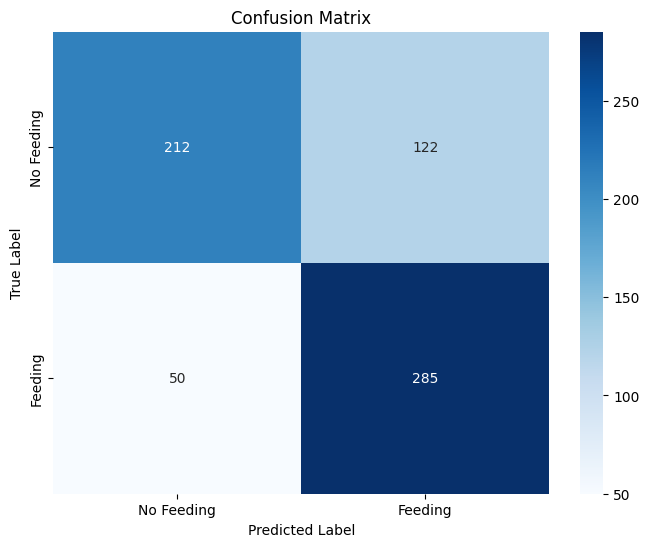

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Feeding", "Feeding"],
            yticklabels=["No Feeding", "Feeding"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()